# MNIST-Overfit-Weight-Decay

In [1]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import math

sys.path.append(os.pardir)
from common.mnist import *
from common.networks import *

## Multilayer Neural Network Model (Two Hidden Layers) and Learing/Validation

In [4]:
activation_layers = {
    'Sigmoid': Sigmoid,
    'ReLU': ReLU
}

optimizers = {
    "SGD": SGD,
    "Momentum": Momentum,
    "Nesterov": Nesterov,
    "AdaGrad": AdaGrad,
    "RMSprop": RMSprop,
    "Adam": Adam
}

initializers = {
    'Zero': Zero_Initializer,
    'N1': N1_Initializer,
    'N2': N2_Initializer, # We will use this as a new initializer for supporting Batch Normalization
    'Xavier': Xavier_Initializer,
    'He': He_Initializer
}

### Multi Layer Model Class

In [5]:
class MultiLayerNetExtended(MultiLayerNet):
    def __init__(self, input_size, hidden_size_list, output_size, activation='ReLU', initializer='N2', 
                 optimizer='AdaGrad', learning_rate=0.01, use_batch_normalization=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        
        self.use_batch_normalization = use_batch_normalization
        
        # Weight Initialization
        self.params = {}
        self.weight_initialization(initializer)
        
        # Layering
        self.layers = OrderedDict()
        self.last_layer = None
        self.layering(activation)

        # Optimization Method
        self.optimizer = optimizers[optimizer](lr=learning_rate)
    
    def weight_initialization(self, initializer):
        params_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        initializer_obj = initializers[initializer](self.params, 
                                                    params_size_list, 
                                                    self.use_batch_normalization)
        initializer_obj.initialize_params();
        
    def layering(self, activation):
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            if self.use_batch_normalization:
                self.layers['Batch_Normalization' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], 
                                                                                   self.params['beta' + str(idx)])
            self.layers['Activation' + str(idx)] = activation_layers[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithCrossEntropyLoss()  

    def predict(self, x, is_train=False):
        for key, layer in self.layers.items():
            if "BatchNorm" in key:
                x = layer.forward(x, is_train)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t, is_train=False):
        y = self.predict(x, is_train)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x, is_train=False)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy        

    def backpropagation_gradient(self, x, t):
        # forward
        self.loss(x, t, is_train=True)

        # backward
        din = 1
        din = self.last_layer.backward(din)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            din = layer.backward(din)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batch_normalization and idx <= self.hidden_layer_num:
                grads['gamma' + str(idx)] = self.layers['Batch_Normalization' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['Batch_Normalization' + str(idx)].dbeta
                
        return grads

    def learning(self, x_batch, t_batch):
        grads = self.backpropagation_gradient(x_batch, t_batch)
        self.optimizer.update(self.params, grads)

### Training and Evaluation

In [6]:
data = mnist_data("/Users/yhhan/git/aiclass/0.Professor/data/MNIST_data/.")
(img_train, label_train), (img_validation, label_validation), (img_test, label_test) = data.load_mnist(flatten=True, normalize=True, one_hot_label=True)

input_size=784
hidden_layer1_size=128
hidden_layer2_size=128
hidden_layer3_size=128
hidden_layer4_size=128
hidden_layer5_size=128
hidden_layer6_size=128
output_size=10

num_epochs = 20
train_size = img_train.shape[0]
batch_size = 100
learning_rate = 0.1

markers = {"N2, SGD, No_Batch_Norm": "x", "N2, SGD, Batch_Norm": "o", 
           "N2, AdaGrad, No_Batch_Norm": "+", "N2, AdaGrad, Batch_Norm": "*",
           "He, AdaGrad, No_Batch_Norm": "h", "He, AdaGrad, Batch_Norm": "H"}

networks = {}
train_errors = {}
validation_errors = {}
test_accuracy_values = {}
max_test_accuracy_epoch = {}
max_test_accuracy_value = {}

for key in markers.keys():
    if key == "N2, SGD, No_Batch_Norm":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='N2',
                                optimizer='SGD', learning_rate=learning_rate,
                                use_batch_normalization=False)
    elif key == "N2, SGD, Batch_Norm":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='N2',
                                optimizer='SGD', learning_rate=learning_rate,
                                use_batch_normalization=True)
    elif key == "N2, AdaGrad, No_Batch_Norm":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='N2',
                                optimizer='AdaGrad', learning_rate=learning_rate,
                                use_batch_normalization=False)
    elif key == "N2, AdaGrad, Batch_Norm":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='N2',
                                optimizer='AdaGrad', learning_rate=learning_rate,
                                use_batch_normalization=True)
    elif key == "He, AdaGrad, No_Batch_Norm":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='He',
                                optimizer='AdaGrad', learning_rate=learning_rate,
                                use_batch_normalization=False)
    elif key == "He, AdaGrad, Batch_Norm":
        networks[key] = MultiLayerNetExtended(input_size, [hidden_layer1_size, hidden_layer2_size], output_size, 
                                activation='ReLU', 
                                initializer='He',
                                optimizer='AdaGrad', learning_rate=learning_rate,
                                use_batch_normalization=True)
        
    train_errors[key] = [] 
    validation_errors[key] = []
    test_accuracy_values[key] = []
    max_test_accuracy_epoch[key] = 0
    max_test_accuracy_value[key] = 0.0

In [7]:
epoch_list = []

num_batch = math.ceil(train_size / batch_size)

for i in range(num_epochs):
    epoch_list.append(i)
    for key in markers.keys():
        for k in range(num_batch):
            x_batch = img_train[k * batch_size : k * batch_size + batch_size]
            t_batch = label_train[k * batch_size : k * batch_size + batch_size]
            networks[key].learning(x_batch, t_batch)

        train_loss = networks[key].loss(x_batch, t_batch, is_train=True)
        train_errors[key].append(train_loss)

        validation_loss = networks[key].loss(img_validation, label_validation, is_train=False)
        validation_errors[key].append(validation_loss)    

        test_accuracy = networks[key].accuracy(img_test, label_test)
        test_accuracy_values[key].append(test_accuracy)
        if test_accuracy > max_test_accuracy_value[key]:
            max_test_accuracy_epoch[key] = i            
            max_test_accuracy_value[key] = test_accuracy
        print("{0:26s}-Epoch:{1:3d}, Train Err.:{2:7.5f}, Validation Err.:{3:7.5f}, Test Accuracy:{4:7.5f}, Max Test Accuracy:{5:7.5f}".format(
            key,
            i,
            train_loss,
            validation_loss,
            test_accuracy,
            max_test_accuracy_value[key]
        ))
    print()    

N2, SGD, No_Batch_Norm    -Epoch:  0, Train Err.:2.30142, Validation Err.:2.30115, Test Accuracy:0.11350, Max Test Accuracy:0.11350
N2, SGD, Batch_Norm       -Epoch:  0, Train Err.:2.30076, Validation Err.:2.30081, Test Accuracy:0.11350, Max Test Accuracy:0.11350
N2, AdaGrad, No_Batch_Norm-Epoch:  0, Train Err.:0.28646, Validation Err.:0.27083, Test Accuracy:0.89810, Max Test Accuracy:0.89810
N2, AdaGrad, Batch_Norm   -Epoch:  0, Train Err.:0.08490, Validation Err.:0.12210, Test Accuracy:0.95600, Max Test Accuracy:0.95600
He, AdaGrad, No_Batch_Norm-Epoch:  0, Train Err.:0.27105, Validation Err.:0.23288, Test Accuracy:0.91000, Max Test Accuracy:0.91000
He, AdaGrad, Batch_Norm   -Epoch:  0, Train Err.:0.08500, Validation Err.:0.11982, Test Accuracy:0.95650, Max Test Accuracy:0.95650

N2, SGD, No_Batch_Norm    -Epoch:  1, Train Err.:2.29994, Validation Err.:2.29949, Test Accuracy:0.11350, Max Test Accuracy:0.11350
N2, SGD, Batch_Norm       -Epoch:  1, Train Err.:2.29402, Validation Err.:2

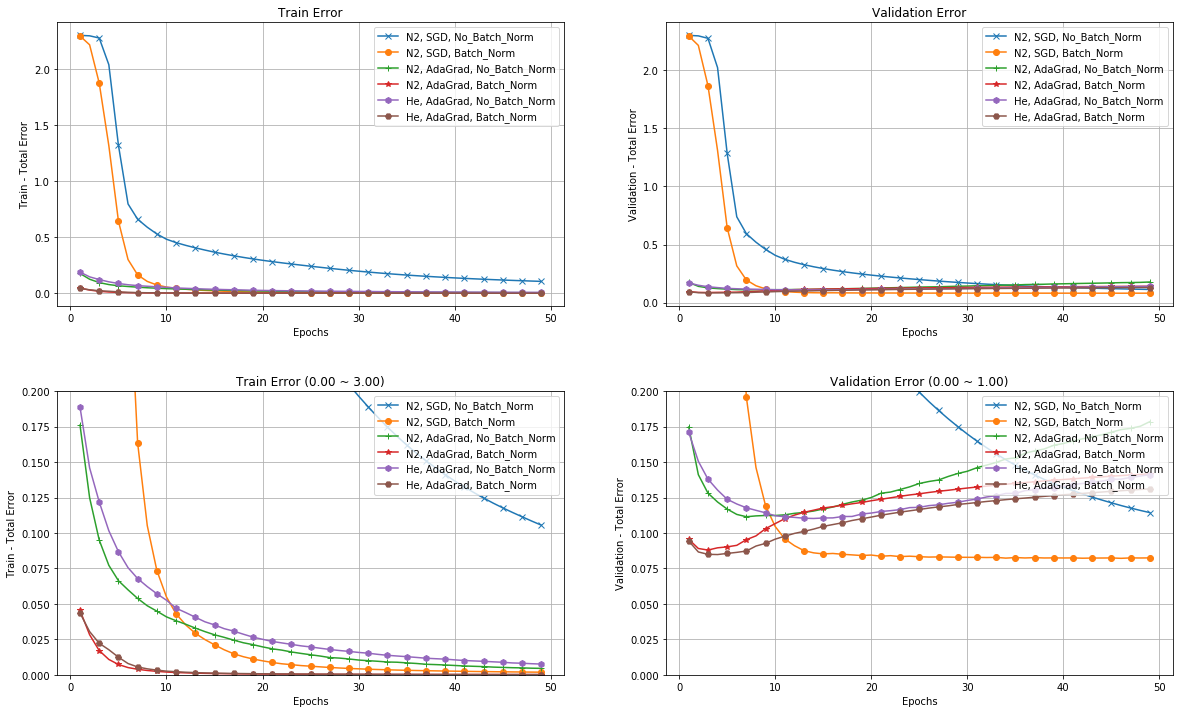

In [11]:
f, axarr = plt.subplots(2, 2, figsize=(20, 12))
for key in markers.keys():
    axarr[0, 0].plot(epoch_list[1:], train_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[0, 0].set_ylabel('Train - Total Error')
axarr[0, 0].set_xlabel('Epochs')
axarr[0, 0].grid(True)
axarr[0, 0].set_title('Train Error')
axarr[0, 0].legend(loc='upper right')

for key in markers.keys():
    axarr[0, 1].plot(epoch_list[1:], validation_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[0, 1].set_ylabel('Validation - Total Error')
axarr[0, 1].set_xlabel('Epochs')
axarr[0, 1].grid(True)
axarr[0, 1].set_title('Validation Error')
axarr[0, 1].legend(loc='upper right')

for key in markers.keys():
    axarr[1, 0].plot(epoch_list[1:], train_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[1, 0].set_ylabel('Train - Total Error')
axarr[1, 0].set_xlabel('Epochs')
axarr[1, 0].grid(True)
axarr[1, 0].set_ylim(0, 0.2)
axarr[1, 0].set_title('Train Error (0.00 ~ 3.00)')
axarr[1, 0].legend(loc='upper right')

for key in markers.keys():
    axarr[1, 1].plot(epoch_list[1:], validation_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[1, 1].set_ylabel('Validation - Total Error')
axarr[1, 1].set_xlabel('Epochs')
axarr[1, 1].grid(True)
axarr[1, 1].set_ylim(0, 0.2)
axarr[1, 1].set_title('Validation Error (0.00 ~ 1.00)')
axarr[1, 1].legend(loc='upper right')

f.subplots_adjust(hspace=0.3)

plt.show()

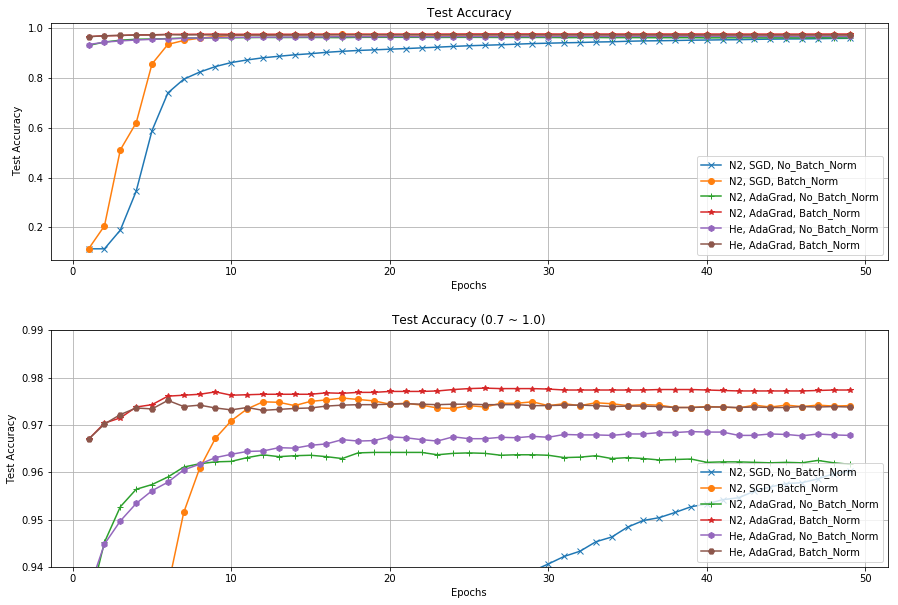

In [17]:
f, axarr = plt.subplots(2, 1, figsize=(15,10))
for key in markers.keys():
    axarr[0].plot(epoch_list[1:], test_accuracy_values[key][1:], marker=markers[key], markevery=1, label=key)
axarr[0].set_ylabel('Test Accuracy')
axarr[0].set_xlabel('Epochs')
axarr[0].grid(True)
axarr[0].set_title('Test Accuracy')
axarr[0].legend(loc='lower right')

for key in markers.keys():
    axarr[1].plot(epoch_list[1:], test_accuracy_values[key][1:], marker=markers[key], markevery=1, label=key)
axarr[1].set_ylabel('Test Accuracy')
axarr[1].set_xlabel('Epochs')
axarr[1].grid(True)
axarr[1].set_ylim(0.94, 0.99)
axarr[1].set_title('Test Accuracy (0.7 ~ 1.0)')
axarr[1].legend(loc='lower right')

f.subplots_adjust(hspace=0.3)
plt.show()

In [16]:
for key in markers.keys():
    print("{0:26s} - Epoch:{1:3d}, Max Test Accuracy: {2:7.5f}".format(key, max_test_accuracy_epoch[key], max_test_accuracy_value[key]))

N2, SGD, No_Batch_Norm     - Epoch: 49, Max Test Accuracy: 0.96020
N2, SGD, Batch_Norm        - Epoch: 17, Max Test Accuracy: 0.97570
N2, AdaGrad, No_Batch_Norm - Epoch: 19, Max Test Accuracy: 0.96420
N2, AdaGrad, Batch_Norm    - Epoch: 26, Max Test Accuracy: 0.97780
He, AdaGrad, No_Batch_Norm - Epoch: 39, Max Test Accuracy: 0.96860
He, AdaGrad, Batch_Norm    - Epoch:  6, Max Test Accuracy: 0.97520
